# Sequential Monte Carlo

#### Sequential Monte Carlo with fixed geometric path

In [1]:
# Autoreload all modules
%load_ext autoreload
%autoreload 2

import jax
import jax.numpy as jnp
import jax.random as jr
import pylab as plt

# add ../mcjax to the path
import sys
sys.path.append('../../')

from mcjax.smc.geometric_smc import GeometricSMC
from mcjax.proba.gaussian import IsotropicGauss
from mcjax.proba.neal_funnel import NealFunnel
from mcjax.proba.student import Student

In [2]:
# initialize jax RNG
key = jr.key(0)

In [3]:
dim = 2
mu_0 = jnp.zeros(dim)
sigma_0 = 1.
log_var_0 = jnp.log(sigma_0**2)
log_gamma_0 = IsotropicGauss(mu=mu_0, log_var=log_var_0)

log_gamma_T = NealFunnel()



In [4]:
N = 10
coefs = (jnp.arange(N+1)/N).tolist()
print(coefs)

step_size = 2.
num_substeps = 5

[0.0, 0.10000000149011612, 0.20000000298023224, 0.30000001192092896, 0.4000000059604645, 0.5, 0.6000000238418579, 0.699999988079071, 0.800000011920929, 0.8999999761581421, 1.0]


In [5]:
GSMC = GeometricSMC(log_gamma_0=log_gamma_0,log_gamma_T=log_gamma_T,coefs=coefs,\
                     step_size=step_size,num_substeps=num_substeps)

In [6]:
GSMC_run = jax.jit(GSMC.run, static_argnums=(0,2))

In [7]:
num_particles = 10_000
key, key_ = jr.split(key)
mc_method = "MALA"
states = GSMC_run(num_particles=num_particles,key=key_,mc_method=mc_method)

C:\Users\Hangao Liang\AppData\Local\Temp\ipykernel_5944\3663654389.py:11: UserWarning: The following kwargs were not used by contour: 'color', 'label'
  plt.contour(X, Y, Z_T,color = 'b',label="Final(Theoritical)",cmap='bwr', origin='lower')
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


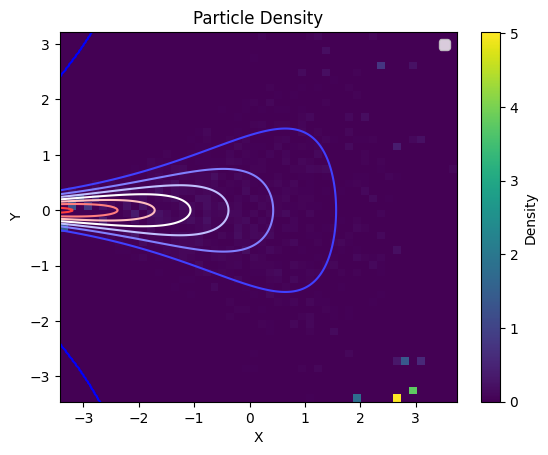

In [8]:
# draw theoritical distribution and samples for t = 0 and t = T
xmin, xmax = -5, 5
ymin, ymax = -5, 5
N_discr = 500
X, Y = jnp.meshgrid(jnp.linspace(xmin, xmax, N_discr), jnp.linspace(ymin, ymax, N_discr), indexing='ij')
X_flat = X.ravel()
Y_flat = Y.ravel()

Z_T = jnp.exp(log_gamma_T.batch(jnp.array([X_flat, Y_flat]).T)).reshape(X.shape)
plt.figure()
plt.contour(X, Y, Z_T,color = 'b',label="Final(Theoritical)",cmap='bwr', origin='lower')

# draw the density of sampled particles
particles = states[-1]["particles"]
plt.hist2d(particles[:,0], particles[:,1], bins=50, cmap='viridis', density=True)
plt.colorbar(label='Density')

# Labels and title
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Particle Density')

# Show plot
plt.legend()
plt.show()


### Adaptive Temperature

In [9]:
num_particles = 10_000
key, key_ = jr.split(key)
mc_method = "RWM"
states = GSMC.selfadaptive_run(num_particles=num_particles,key=key_,mc_method=mc_method)

C:\Users\Hangao Liang\AppData\Local\Temp\ipykernel_5944\3663654389.py:11: UserWarning: The following kwargs were not used by contour: 'color', 'label'
  plt.contour(X, Y, Z_T,color = 'b',label="Final(Theoritical)",cmap='bwr', origin='lower')
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


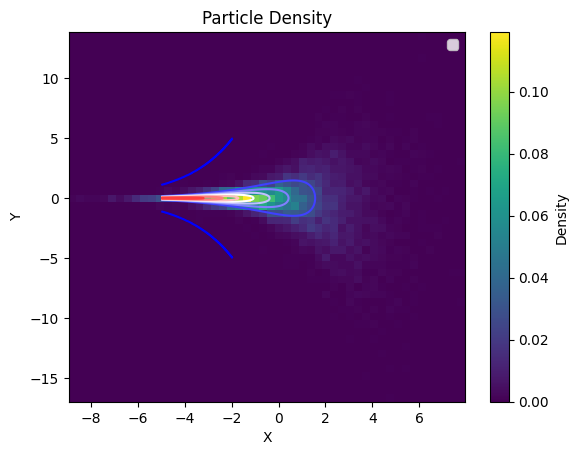

In [10]:
# draw theoritical distribution and samples for t = 0 and t = T
xmin, xmax = -5, 5
ymin, ymax = -5, 5
N_discr = 500
X, Y = jnp.meshgrid(jnp.linspace(xmin, xmax, N_discr), jnp.linspace(ymin, ymax, N_discr), indexing='ij')
X_flat = X.ravel()
Y_flat = Y.ravel()

Z_T = jnp.exp(log_gamma_T.batch(jnp.array([X_flat, Y_flat]).T)).reshape(X.shape)
plt.figure()
plt.contour(X, Y, Z_T,color = 'b',label="Final(Theoritical)",cmap='bwr', origin='lower')

# draw the density of sampled particles
particles = states[-1]["particles"]
plt.hist2d(particles[:,0], particles[:,1], bins=50, cmap='viridis', density=True)
plt.colorbar(label='Density')

# Labels and title
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Particle Density')

# Show plot
plt.legend()
plt.show()


-0.0970922 2.315211


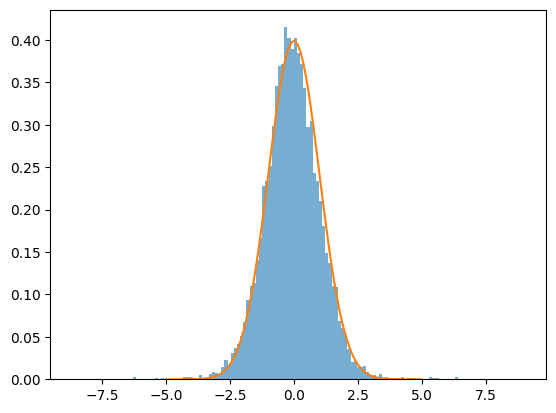

In [24]:
plt.figure()
# plt.hist(particles[:,0], bins="auto", density=True, alpha=0.6, label='X')
print(jnp.mean(particles[:,0]),jnp.std(particles[:,0]))
plt.hist(particles[:,1]*jnp.exp(-particles[:,0]/2), bins="auto", density=True, alpha=0.6, label='Y')
# compare with N(0,1)
X = jnp.linspace(-5,5,100)  
plt.plot(X,jnp.exp(-X**2/2)/jnp.sqrt(2*jnp.pi),label="N(0,1)")



#### Variation of temperature in the geometric path

[0.0, 0.2936668395996094, 0.5664769216818968, 0.7148488986889753, 0.7817029433612761, 0.8387787500248585, 0.8870496754248254, 0.9362344954127149, 0.9757493372141497, 1.0, 1.0]


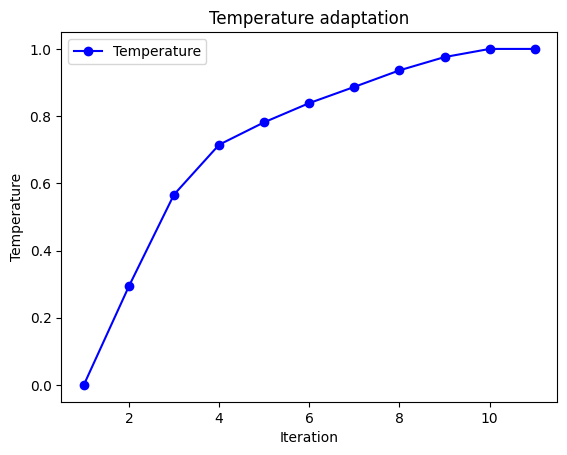

In [11]:
temperature_adapted = GSMC.coefs
plt.plot(jnp.arange(1,len(temperature_adapted)+1),temperature_adapted, label='Temperature', color='b', marker='o')
plt.xlabel('Iteration')
plt.ylabel('Temperature')
plt.legend()    
plt.title('Temperature adaptation')
print(temperature_adapted)
